# Analysis Report
In this analysis, I conclude what will help to *increase revenue* and to *improve our cross-selling campaign*.

In [1]:
#Import nescesarry models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import gender_guesser.detector as gender
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier      

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# specifying file name
file = './datasets/Apprentice_Chef_Dataset.xlsx'

# reading the file into Python
chef = pd.read_excel(io = file)

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# specifying file name
file = './datasets/Apprentice_Chef_Dataset.xlsx'

# reading the file into Python
chef = pd.read_excel(io = file)

# Making the labels more readable and chaning Largest order size
chef_cap = chef.rename(str.capitalize, axis='columns')
chef_new = chef_cap.rename(columns={"Largest_order_size" : "Avg_meals_pc"})

In [2]:
# Dummy variables for inregulare variables
chef_new['Customers_have_viewed_photos']        = 0
chef_new['Regular_contact_w_customer_service']  = 0
chef_new['On_time_delivery']                    = 0
chef_new['Customers_have_logged_in']            = 0 
chef_new['Customers_have_purch_unique_meals']   = 0

# Start for-loop
for index, value in chef_new.iterrows():
    
    # Has viewed photos 
    if chef_new.loc[index, 'Total_photos_viewed'] > 0:
        chef_new.loc[index, 'Customers_have_viewed_photos'] = 1
        
    # Regular_contact (x > 10)
    if chef_new.loc[index, 'Contacts_w_customer_service'] > 10:
        chef_new.loc[index, 'Regular_contact_w_customer_service'] = 1
        
    # On-time delivery 
    if chef_new.loc[index, 'Early_deliveries'] == 0 and \
       chef_new.loc[index, 'Late_deliveries'] == 0:
        chef_new.loc[index, 'On_time_delivery'] = 1
        
    # Has logins
        if chef_new.loc[index, 'Mobile_logins'] > 0:
            chef_new.loc[index, 'Customers_have_logged_in'] = 1
            
    # Has Unique meals purchased
        if chef_new.loc[index, 'Unique_meals_purch'] > 1:
            chef_new.loc[index, 'Customers_have_purch_unique_meals'] = 1

In [3]:
# Transforming variables to normalize them 
chef_new['log_Total_meals_ordered'] = np.log10(chef_new['Total_meals_ordered'])
chef_new['log_Unique_meals_purch'] = np.log10(chef_new['Unique_meals_purch'])
chef_new['log_Avg_prep_vid_time'] = np.log10(chef_new['Avg_prep_vid_time'])
chef_new['log_Total_photos_viewed'] = np.log10(chef_new['Total_photos_viewed']+0.1)
chef_new['log_Revenue'] = np.log10(chef_new['Revenue'])

In [4]:
# STEP 1: Splitting emails

# Placeholder list: Email_group
Email_group = []

# Looping over each email address
for index, col in chef_new.iterrows():
    
    # Splitting email domain at '@'
    split_email = chef_new.loc[index, 'Email'].split(sep = '@')
    
    # Appending placeholder_lst with the results
    Email_group.append(split_email)
    
# Converting placeholder_lst into a DataFrame 
email_df = pd.DataFrame(Email_group)

In [5]:
# STEP 2: Concatenating with original DataFrame

# Renaming column to concatenate
email_df.columns = ['0' , 'Email_domain']

# Concatenating Email_domain with chef_new DataFrame
chef_new = pd.concat([chef_new, email_df['Email_domain']],
                      axis = 1)

In [6]:
# Step 3: Renaming emails acoording to their domain category

# Email domain types
Personal = ['@gmail.com','@yahoo.com','@protonmail.com']
Junk  = ['@me.com','@aol.com','@hotmail.com','@live.com','@msn.com','@passport.com']

# Placeholder list: Email_group
Email_group = []

# Looping to group observations by domain type
for domain in chef_new['Email_domain']:
        if '@' + domain in Personal:
            Email_group.append('Personal')
        elif '@' + domain in Junk:
            Email_group.append('Junk')
        else:
            Email_group.append('Professional')

# Concatenating with original DataFrame
chef_new['Email_group'] = pd.Series(Email_group)

In [7]:
# Step 4: Creating dummies per category

# One hot encoding categorical variables
one_hot_Email_group = pd.get_dummies(chef_new['Email_group'])

# Dropping categorical variables after they've been encoded
chef_new = chef_new.drop('Email_group', axis = 1)

# Joining codings together
chef_new = chef_new.join([one_hot_Email_group])

# Saving new columns
new_columns = chef_new.columns

In [8]:
# User Defined Function for splitting names 
def text_split_feature(col, df, sep=' ', new_col_name='Number_of_names'):

    df[new_col_name] = 0
    
    for index, val in df.iterrows():
        df.loc[index, new_col_name] = len(df.loc[index, col].split(sep = ' '))

In [9]:
# calling text_split_feature
text_split_feature(col = 'Name',
                   df  = chef_new)

In [10]:
# Creating list with gender guesses
Gender_guess = ['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'mostly_male', 'female', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'male', 'unknown', 'female', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'female', 'female', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'mostly_male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'mostly_male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'mostly_male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'mostly_male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'andy', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'andy', 'male', 'unknown', 'unknown', 'male', 'male', 'female', 'female', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'female', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'mostly_female', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'mostly_female', 'unknown', 'male', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'female', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'male', 'mostly_male', 'male', 'male', 'male', 'male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'andy', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'female', 'male', 'male', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'andy', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown', 'male', 'unknown', 'mostly_female', 'male', 'unknown', 'unknown', 'female', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'female', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'mostly_male', 'mostly_male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'female', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'mostly_male', 'unknown', 'unknown', 'male', 'andy', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'male', 'female', 'mostly_female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'mostly_female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'female', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'mostly_female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'mostly_female', 'female', 'female', 'male', 'male', 'male', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'female', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'andy', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'male', 'unknown', 'male', 'unknown', 'mostly_male', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'mostly_male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'andy', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown']
 
# Transform the list into a new column
chef_new['Gender_guess'] = Gender_guess

In [11]:
# Change mostly female and mostly male to female and male
chef_new['Gender_guess'].replace('mostly_female','female', inplace=True)
chef_new['Gender_guess'].replace('mostly_male','male', inplace=True)
chef_new['Gender_guess'].replace('andy','male', inplace=True)

In [12]:
# One hot encoding categorical variables
one_hot_Gender = pd.get_dummies(chef_new['Gender_guess'])

# Dropping categorical variables after they've been encoded
chef_new = chef_new.drop('Gender_guess', axis = 1)

# Joining codings together
chef_new = chef_new.join([one_hot_Gender])

# Saving new columns
new_columns = chef_new.columns

In [13]:
# Dropping Professional dummie and all other remaining categorical columns 
chef_fin = chef_new.drop(['Professional','Email_domain', 'Email', 'Name', 
                          'First_name', 'Family_name', 'unknown'], 
                          axis = 1)

chef_fin.head(n=5)

,Revenue,Cross_sell_success,Total_meals_ordered,Unique_meals_purch,Contacts_w_customer_service,Product_categories_viewed,Avg_time_per_site_visit,Mobile_number,Cancellations_before_noon,Cancellations_after_noon,Tastes_and_preferences,Pc_logins,Mobile_logins,Weekly_plan,Early_deliveries,Late_deliveries,Package_locker,Refrigerated_locker,Avg_prep_vid_time,Avg_meals_pc,Master_classes_attended,Median_meal_rating,Avg_clicks_per_visit,Total_photos_viewed,Customers_have_viewed_photos,Regular_contact_w_customer_service,On_time_delivery,Customers_have_logged_in,Customers_have_purch_unique_meals,log_Total_meals_ordered,log_Unique_meals_purch,log_Avg_prep_vid_time,log_Total_photos_viewed,log_Revenue,Junk,Personal,Number_of_names,female,male
0,393.0,1,14,6,12,10,48.00,1,3,1,1,5,2,0,0,2,0,0,33.4,1,0,1,17,0,0,1,0,0,0,1.146128,0.778151,1.523746,-1.000000,2.594393,0,0,1,0,0
1,1365.0,1,87,3,8,8,40.35,1,0,0,1,5,1,12,0,2,0,0,84.8,1,0,3,13,170,1,0,0,0,0,1.939519,0.477121,1.928396,2.230704,3.135133,0,0,2,0,0
2,800.0,1,15,7,11,5,19.77,1,3,0,1,6,1,1,0,1,0,0,63.0,1,0,2,16,0,0,1,0,0,0,1.176091,0.845098,1.799341,-1.000000,2.903090,0,0,2,0,0
3,600.0,1,13,6,11,5,90.00,1,2,0,1,6,1,14,0,3,0,0,43.8,1,0,2,14,0,0,1,0,0,0,1.113943,0.778151,1.641474,-1.000000,2.778151,0,0,2,0,0
4,1490.0,1,47,8,6,10,40.38,1,0,0,0,5,1,5,0,8,0,0,84.8,1,1,3,12,205,1,0,0,0,0,1.672098,0.903090,1.928396,2.311966,3.173186,0,0,2,0,0


# Regression Analysis - Revenue

In [14]:
# Declaring set of x-variables for Log Revenue
x_variables = ['Cross_sell_success','Contacts_w_customer_service',
               'Avg_prep_vid_time','Avg_meals_pc','Master_classes_attended',
               'Median_meal_rating','Regular_contact_w_customer_service',
               'Customers_have_viewed_photos','On_time_delivery',
               'Customers_have_logged_in','Customers_have_purch_unique_meals',
               'male','log_Total_meals_ordered','log_Unique_meals_purch',
               'log_Avg_prep_vid_time','log_Total_photos_viewed']

In [15]:
# Preparing x-variables from the OLS model
regr_data   = chef_fin[x_variables]

# Preparing response variable
regr_target = chef_fin.loc[ : , 'log_Revenue']

# OLS log_X-dataset (normal Y)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(regr_data,
                                                            regr_target,
                                                            test_size = 0.25,
                                                            random_state = 219)

In [16]:
# INSTANTIATING a model object
lr = LinearRegression()

# FITTING to the training data
lr_fit = lr.fit(X_train_r, y_train_r)

# PREDICTING on new data
lr_pred = lr_fit.predict(X_test_r)

In [17]:
# Zipping each feature name to its coefficient
lr_values = zip(regr_data[x_variables].columns,
                    lr_fit.coef_.round(decimals = 2))

# Setting up a placeholder list to store model features
lr_lst = [('intercept', lr_fit.intercept_.round(decimals = 2))]

# Printing out each feature-coefficient pair one by one
for val in lr_values:
    lr_lst.append(val)
    
# Checking the results
for pair in lr_lst:
    print(pair)

('intercept', 1.97)
('Cross_sell_success', -0.02)
('Contacts_w_customer_service', 0.02)
('Avg_prep_vid_time', 0.0)
('Avg_meals_pc', -0.01)
('Master_classes_attended', 0.03)
('Median_meal_rating', 0.06)
('Regular_contact_w_customer_service', -0.22)
('Customers_have_viewed_photos', -0.11)
('On_time_delivery', 0.06)
('Customers_have_logged_in', 0.06)
('Customers_have_purch_unique_meals', -0.13)
('male', 0.01)
('log_Total_meals_ordered', 0.16)
('log_Unique_meals_purch', -0.16)
('log_Avg_prep_vid_time', 0.38)
('log_Total_photos_viewed', 0.04)


**From the regression analysis, I have found the following two insights:**

-	*For every additional percentage a meal-prep video was playing, revenue **increased by 38%**.* 

Meaning the more people engage with videos, the more they spend. I recommend increasing the amount of video content with clear, fun videos, so people not only want to watch them, but also watch them until the end. This will motivate them to purchase the meal that was displayed in the video. 

-	*For people that contact customer service regularly, revenue will **decrease by 22%** with every additional contact.* 

We need to make sure people do not have to contact customer service regularly. I recommend increasing the FAQ, so more answers are easily found through the website. Additionally, I recommend decreasing the number of steps needed to order a meal, so there is less confusion in the ordering process. 


# Classification Analysis - Cross-sell-success

In [18]:
# creating a dictionary to store candidate models
candidate_dict = {
  # significant variables only
  'logit_sig2'   : ['Mobile_number','Cancellations_before_noon',
                    'Tastes_and_preferences','Pc_logins','Early_deliveries',
                    'Refrigerated_locker','Avg_prep_vid_time',
                    'Junk','Personal','Number_of_names'],
}

In [19]:
# train/test split with the sig model
chef_data   =  chef_fin.loc[ : , candidate_dict['logit_sig2']]
chef_target =  chef_fin.loc[ : , 'Cross_sell_success']

# this is the exact code we were using before
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(chef_data,
                                                            chef_target,
                                                            random_state = 219,
                                                            test_size    = 0.25,
                                                            stratify     = chef_target)

In [20]:
# INSTANTIATING a classification tree object
pruned_tree = DecisionTreeClassifier(splitter          = 'best',
                                     min_samples_split = 14,
                                     min_samples_leaf  = 16,
                                     max_leaf_nodes    = 16,
                                     max_features      = None,
                                     max_depth         = 3,
                                     criterion         = 'entropy',
                                     random_state      = 219)


# FITTING the training data
pruned_tree_fit  = pruned_tree.fit(chef_data, chef_target)


# PREDICTING on new data
pruned_tree_pred = pruned_tree_fit.predict(X_test_c)

In [21]:
# Create User Defined Functions for coming plots 

########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    
    # Visualizing the confusion matrix

    # Setting labels
    lbls = labels

    # Declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)
    
    # Heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')

    # Create visualization labels/titles and show
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()
    
########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):

    # declaring the number
    n_features = X_train_c.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

<ipython-input-21-0658a37308e7>:43: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  plt.yticks(pd.np.arange(n_features), train.columns)


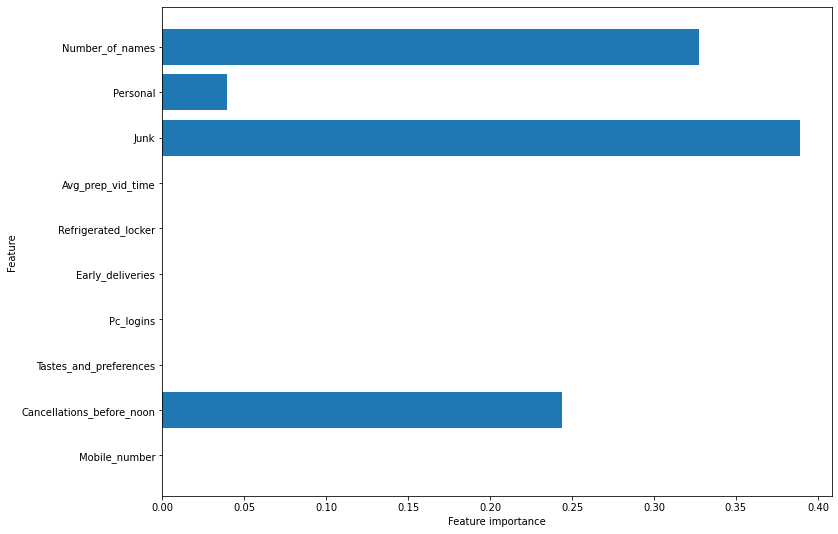

In [22]:
# plotting feature importance
plot_feature_importances(pruned_tree_fit,
                         train  = X_train_c,
                         export = False)

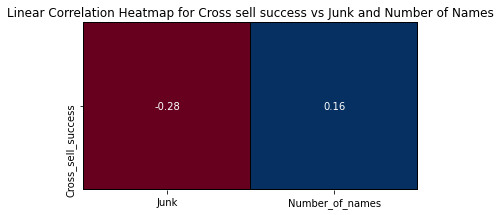

In [23]:
# Create Pearson correlation 
df_corr = chef_fin.corr(method = 'pearson').round(decimals = 2)

# specifying plot size 
fig, ax = plt.subplots()

# developing a spicy heatmap
sns.heatmap(data       = df_corr.loc[ ['Cross_sell_success'] , ['Junk', 'Number_of_names'] ],
            cmap       = 'RdBu',    
            square     = True,        
            annot      = True,          
            linecolor  = 'black',      
            linewidths = 0.5, 
            cbar       = False)          

# title and displaying the plot
plt.title("""Linear Correlation Heatmap for Cross sell success vs Junk and Number of Names""")
plt.show()

**From the Classification Analysis I have found the following 2 insights:**

-	The most important influence on this campaign is people who are having a **Junk email-domain**. However, since it is a negative influence, we need to target people who **don’t** have this. 

-	The second influencer is **Number of Names**. This probably has to do with the **formality** of subscription. People who provided us more names (incl. formal ones) buy more wine. Therefore, I recommend being more formal in our communication and target people with more names. 


## Conclusion

In [24]:
# SCORING the model REGRESSION
print('OLS Training Log Score :', lr.score(X_train_r, y_train_r).round(3)) # using R-square
print('OLS Testing Log Score  :', lr.score(X_test_r, y_test_r).round(3)) # using R-square

# Saving scoring data for future use
lr_train_score = lr.score(X_train_r, y_train_r).round(3)
lr_test_score  = lr.score(X_test_r, y_test_r).round(3)

# Displaying and saving the gap between training and testing
print('OLS Train-Test Log Gap :', abs(lr_train_score - lr_test_score).round(3))
lr_test_gap = abs(lr_train_score - lr_test_score).round(3)

OLS Training Log Score : 0.752
OLS Testing Log Score  : 0.754
OLS Train-Test Log Gap : 0.002


In [25]:
# SCORING the model CLASSIFICATION
print('Training ACCURACY:', pruned_tree_fit.score(X_train_c, y_train_c).round(3))
print('Testing  ACCURACY:', pruned_tree_fit.score(X_test_c, y_test_c).round(3))
print('AUC Score        :', roc_auc_score(y_true  = y_test_c,
                                          y_score = pruned_tree_pred).round(4))


# saving scoring data for future use
pruned_tree_train_score = pruned_tree_fit.score(X_train_c, y_train_c).round(4) # accuracy
pruned_tree_test_score  = pruned_tree_fit.score(X_test_c, y_test_c).round(4)   # accuracy


# saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test_c,
                                        y_score = pruned_tree_pred).round(4) # auc

Training ACCURACY: 0.74
Testing  ACCURACY: 0.776
AUC Score        : 0.732


The R-square of my revenue regression model is: **0.754** \
The AUC score of my cross-sell classification model is: **0.732**

The higher these numbers, the better the model. I used them to choose the best performing models with the most accurate predictions. 